# Results

In [1]:
from os import makedirs
from os.path import join

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes
from matplotlib.legend import Legend


plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{cmbright}',
    'text.usetex': True,
    'font.family': 'serif',
})
color_palette = sns.color_palette('deep')
plt.rc('grid', linestyle="dotted", color='lightgrey')

results_dir = '../rpaper'
plots_dir = 'paper_plots'

arch_name = {
    'convnext-atto': 'ConvnextAtto',
    'convnext-tiny': 'ConvNextTiny',
    'convnextv2-atto': 'Convnextv2Atto',
    'convnextv2-nano': 'Convnextv2Nano',
    'convnextv2-tiny': 'Convnextv2Tiny',
    'densenet121': 'DenseNet121',
    'densenet161': 'DenseNet161',
    'mobilenetv3-small-075': 'MobileNetV3-Small-0.75',
    'mobilenetv3-large-100': 'MobileNetV3-Large-1.0',
    'mobilevitv2-050': 'MobileViTv2-0.5',
    'mobilevitv2-100': 'MobileViTv2-1.0',
    'mobilevitv2-200': 'MobileViTv2-2.0',

}

def format_pm(s: str) -> str:
    if isinstance(s, str) and '±' in s:
        return s.replace('±', '\\pm')
    else:
        return s

makedirs(plots_dir, exist_ok=True)

### Arch

In [2]:
def load_arch_df():
    df = pd.read_csv(join(results_dir, 'arch_batch-size-48', 'exp_mtst.csv'))
    df['Arch'] = df['run']
    df['Unseen'] = df['unseen']
    df['Seen'] = df['seen']
    df['HM'] = df['hm']
    df = df[['Arch', 'Unseen', 'Seen', 'HM']]
    df = df.set_index('Arch')

    df_params_macs = pd.DataFrame(
        [
            # Efficient
            ('mobilenetv3-small-075',  1.02,  0.12, 'conv'),
            ('mobilevitv2-050',        1.11,  1.05, 'tsfm'),
            ('mobilenetv3-large-100',  4.20,  0.63, 'conv'),
            ('mobilevitv2-100',        4.39,  4.08, 'tsfm'),
            ('convnext-atto',          3.37,  1.62, 'conv'),
            # Large
            ('densenet121',           6.95,   8.33, 'conv'),
            ('densenet161',           26.47, 22.70, 'conv'),
            ('convnext-tiny',         27.82, 28.60, 'conv'),
            ('mobilevitv2-200',       17.42, 16.11, 'tsfm'),
        ],
        columns=['Arch', 'Params', 'MACs', 'CP']
    ).set_index('Arch')


    df = pd.concat([df_params_macs, df], axis=1, join="inner")
    df = df.reset_index()
    df = df.replace(arch_name)
    df = df[['Arch', 'Seen',  'Unseen', 'HM', 'Params', 'MACs', 'CP']]
    return df


arch_df = load_arch_df()
arch_df

,Arch,Seen,Unseen,HM,Params,MACs,CP
0,MobileNetV3-Small-0.75,83.39±0.16,72.74±0.47,74.90±0.36,1.02,0.12,conv
1,MobileViTv2-0.5,83.35±0.16,75.35±0.45,76.63±0.35,1.11,1.05,tsfm
2,MobileNetV3-Large-1.0,84.42±0.15,74.70±0.47,76.57±0.36,4.20,0.63,conv
3,MobileViTv2-1.0,83.14±0.16,76.88±0.44,77.61±0.33,4.39,4.08,tsfm
4,ConvnextAtto,83.54±0.15,73.00±0.44,75.44±0.34,3.37,1.62,conv
5,DenseNet121,81.50±0.17,76.96±0.40,77.20±0.30,6.95,8.33,conv
6,DenseNet161,83.36±0.16,77.83±0.42,78.41±0.31,26.47,22.70,conv
7,ConvNextTiny,85.26±0.14,76.11±0.44,78.07±0.34,27.82,28.60,conv
8,MobileViTv2-2.0,82.98±0.16,77.58±0.43,77.96±0.33,17.42,16.11,tsfm


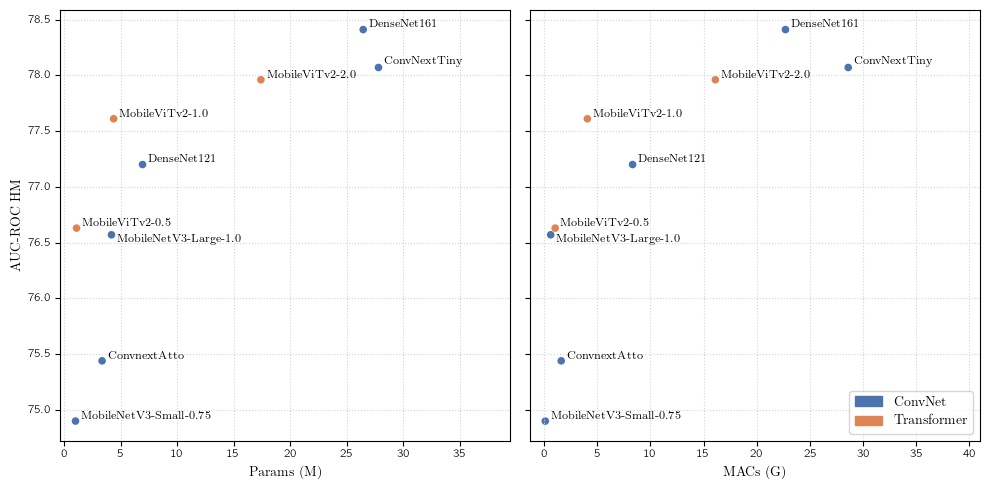

In [3]:
def generate_arch_plot(df: pd.DataFrame):

    df = df.copy()
    df['Unseen'] = df['Unseen'].str[:5].astype(float)
    df['Seen'] = df['Seen'].str[:5].astype(float)
    df['HM'] = df['HM'].str[:5].astype(float)

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
    ax0: Axes = ax0
    ax1: Axes = ax1

    cp_color = {'conv': color_palette[0], 'tsfm': color_palette[1]}
    colors = [cp_color[cp] for cp in df['CP']]
    # _color = color[:len(df)]

    df.plot.scatter('Params', 'HM', ax=ax0, c=colors)
    df.plot.scatter('MACs', 'HM', ax=ax1, c=colors)

    for x, y, arch in zip(df['Params'], df['HM'], df['Arch']):
        if arch == 'MobileNetV3-Large-1.0':
            ax0.text(x+0.5, y, f'{arch}', ha='left', va='top', fontsize='small')
        else:
            ax0.text(x+0.5, y, f'{arch}', ha='left', va='bottom', fontsize='small')
    xmin, xmax = ax0.get_xlim()
    ax0.set_xlim(xmin, xmax + 0.35 * (xmax - xmin))
    ax0.tick_params(axis='both', which='major', labelsize='small', )

    for x, y, arch in zip(df['MACs'], df['HM'], df['Arch']):
        if arch == 'MobileNetV3-Large-1.0':
            ax1.text(x+0.5, y, f'{arch}', ha='left', va='top', fontsize='small')
        else:
            ax1.text(x+0.5, y, f'{arch}', ha='left', va='bottom', fontsize='small')
    xmin, xmax = ax1.get_xlim()
    ax1.set_xlim(xmin, xmax + 0.35 * (xmax - xmin))
    ax1.tick_params(axis='both', which='major', labelsize='small')

    ax0.set_ylabel('AUC-ROC HM')
    ax0.set_xlabel('Params (M)')
    ax1.set_xlabel('MACs (G)')
    ax1.set_yticklabels([])
    ax1.yaxis.label.set_visible(False)

    conv_patch = mpatches.Patch(color=cp_color['conv'], label='ConvNet')
    tsfm_patch = mpatches.Patch(color=cp_color['tsfm'], label='Transformer')
    ax1.legend(handles=[conv_patch, tsfm_patch], loc='lower right')

    # plt.xticks(fontsize='small')
    # plt.yticks(fontsize='small')

    ax0.grid()
    ax1.grid()

    plt.tight_layout()
    plt.savefig(join(plots_dir, "params-macs.pdf"))
    plt.show()

generate_arch_plot(arch_df)

### Resolution

In [4]:
def load_resolution_df():
    df = pd.read_csv(join(results_dir, 'resolution', 'exp_mtst.csv'))
    df[['arch', 'resolution']] = df['run'].str.split('_', expand=True)
    df['Arch'] = df['arch'].astype(str)
    df['Resolution'] = df['resolution'].astype(int)
    df['Unseen'] = df['unseen']
    df['Seen'] = df['seen']
    df['HM'] = df['hm']
    df = df[['Arch', 'Resolution', 'Seen',  'Unseen', 'HM']]
    df = df.replace(arch_name)
    return df

resolution_df = load_resolution_df()
resolution_df

,Arch,Resolution,Seen,Unseen,HM
0,ConvNextTiny,224,84.58±0.15,74.76±0.44,76.95±0.34
1,ConvNextTiny,384,84.53±0.15,76.45±0.43,78.05±0.33
2,ConvNextTiny,512,84.75±0.15,76.58±0.43,78.17±0.33
3,ConvNextTiny,768,84.85±0.15,76.89±0.43,78.45±0.32
4,DenseNet121,224,83.03±0.16,76.84±0.42,77.62±0.32
5,DenseNet121,384,82.36±0.17,77.99±0.43,77.91±0.33
6,DenseNet121,512,82.33±0.17,77.60±0.41,77.92±0.30
7,MobileNetV3-Large-1.0,224,80.82±0.17,71.20±0.44,73.36±0.31
8,MobileNetV3-Large-1.0,384,84.42±0.15,75.25±0.46,76.95±0.35
9,MobileNetV3-Large-1.0,512,84.65±0.15,75.63±0.45,77.34±0.35


Figure(640x480)


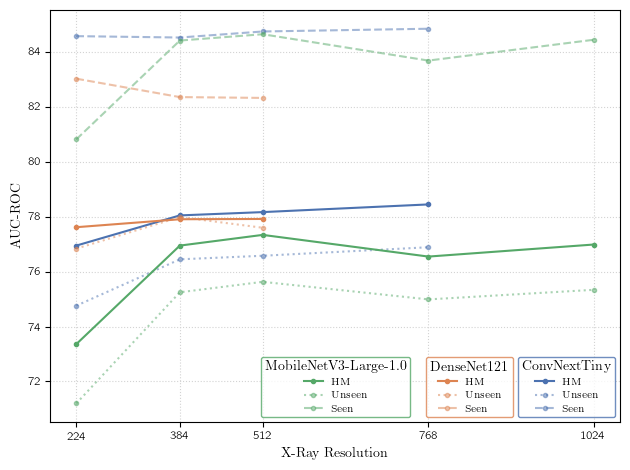

<Figure size 640x480 with 0 Axes>

In [5]:
def generate_resolution_plot(df: pd.DataFrame):
    df = df.copy()
    df['Unseen'] = df['Unseen'].str[:5].astype(float)
    df['Seen'] = df['Seen'].str[:5].astype(float)
    df['HM'] = df['HM'].str[:5].astype(float)

    fig, ax = plt.subplots()
    ax: Axes = ax
    print(plt.figure())

    metrics = {('HM', 1.0, 'solid'), ('Seen', 0.5, 'dashed'), ('Unseen', 0.5, 'dotted')}
    archs = df['Arch'].unique()
    for i, (arch, color) in enumerate(zip(archs, color_palette[:3])):
        arch_df = df[df['Arch'] == arch]
        for metric, alpha, linestyle in metrics:
            ax = arch_df.plot(
                x='Resolution', y=metric,
                ax=ax,
                marker='.', linestyle=linestyle,
                alpha=alpha, color=color,
                # label=f'{metric} {arch}'
            )
            ax.get_legend().remove()

        leg = Legend(ax, ax.get_lines()[-3:],
                     ['HM', 'Unseen', 'Seen'],
                     title=arch,
                     fontsize='x-small',
                     edgecolor=color,
                     loc='lower right')
        bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
        x_offset = i * 0.18
        bb.x0 -= x_offset
        bb.x1 -= x_offset
        leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
        ax.add_artist(leg)

    # ax.legend(archs)
    ax.set_xticks(df['Resolution'].unique())
    ax.set_xlabel('X-Ray Resolution')
    ax.set_ylabel('AUC-ROC')

    ax.tick_params(axis='both', which='major', labelsize='small')
    ax.tick_params(axis='both', which='minor', labelsize='small')

    ax.grid()
    fig.tight_layout()
    fig.savefig(join(plots_dir, 'resolution.pdf'))


generate_resolution_plot(resolution_df)

### Subpop Age

In [6]:
def load_age_df():
    df = pd.read_csv(join(results_dir, 'shift_pop', 'exp_mtst.csv'))
    df = df[df.run.str.startswith('age_decade')]
    df['Decade'] = df['run'].str.split('_', expand=True)[1].str[6:].astype(int)
    df['Unseen'] = df['unseen']
    df['Seen'] = df['seen']
    df['HM'] = df['hm']
    df = df[['Decade', 'Seen',  'Unseen', 'HM']]
    return df

age_df = load_age_df()
age_df


,Decade,Seen,Unseen,HM
2,2,80.01±0.18,80.70±0.35,78.88±0.26
3,3,83.17±0.16,81.28±0.40,80.26±0.30
4,4,83.68±0.15,80.95±0.38,80.60±0.28
5,5,83.50±0.15,80.53±0.41,80.04±0.31
6,6,83.21±0.15,74.31±0.41,76.46±0.30
7,7,84.19±0.15,72.63±0.44,75.61±0.33
8,8,84.27±0.16,72.54±0.43,75.53±0.33


Figure(640x480)


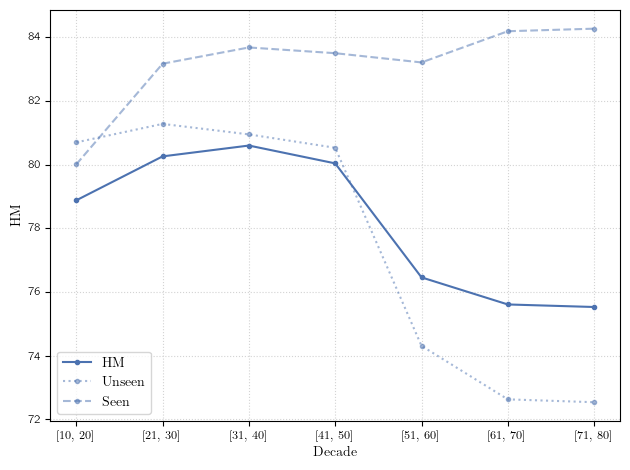

<Figure size 640x480 with 0 Axes>

In [7]:
def generate_age_plot(df: pd.DataFrame):
    df = df.copy()
    df['Unseen'] = df['Unseen'].str[:5].astype(float)
    df['Seen'] = df['Seen'].str[:5].astype(float)
    df['HM'] = df['HM'].str[:5].astype(float)

    fig, ax = plt.subplots()
    ax: Axes = ax
    print(plt.figure())

    df.plot(
        x='Decade', y='HM',
        ax=ax,
        marker='.', linestyle='solid',
        color=color_palette[0]
    )

    df.plot(
        x='Decade', y='Unseen',
        ax=ax,
        marker='.', linestyle='dotted',
        alpha=0.5, color=color_palette[0]
    )

    df.plot(
        x='Decade', y='Seen',
        ax=ax,
        marker='.', linestyle='dashed',
        alpha=0.5, color=color_palette[0]
    )

    labels = ['[10, 20]', '[21, 30]', '[31, 40]', '[41, 50]',
              '[51, 60]', '[61, 70]', '[71, 80]']
    ax.set_xticks(range(2, 9), labels)
    ax.set_xlabel('Decade')
    ax.set_ylabel('HM')

    ax.tick_params(axis='both', which='major', labelsize='small')
    ax.tick_params(axis='both', which='minor', labelsize='small')

    ax.grid()
    fig.tight_layout()
    fig.savefig(join(plots_dir, 'subpop_age.pdf'))


generate_age_plot(age_df)

### From Generalized FSL to Standard FSL

In [8]:
results_dir = '../../Meta-CXR-dev-run/rpaper'

def load_gfsl_df(

    ):
    df = pd.read_csv(join(results_dir, 'gfsl', 'exp_mtst.csv'))

    df[['n-way', 'n-unseen', 'k-shot']] = df['run'].str.split('_', expand=True)
    df['n-way'] = df['n-way'].str[5:].astype(int)
    df['n-unseen'] = df['n-unseen'].str[7:].astype(int)
    df['k-shot'] = df['k-shot'].str[6:].astype(int)
    df['Unseen'] = df['unseen']
    df['Seen'] = df['seen']
    df['HM'] = df['hm']

    df = df[['n-way', 'n-unseen', 'k-shot', 'Seen',  'Unseen', 'HM']]
    return df

gfsl_df = load_gfsl_df()
with open('gfsl.md', 'w') as f:
    f.write(gfsl_df.to_markdown(index=False) + '\n')
with open('gfsl.tex', 'w') as f:
    formatters = [format_pm] * gfsl_df.shape[1]
    f.write(gfsl_df.to_latex(index=False, formatters=formatters))
gfsl_df

,n-way,n-unseen,k-shot,Seen,Unseen,HM
0,3,1,1,78.60±0.22,70.13±0.46,71.36±0.35
1,3,1,5,84.54±0.15,74.50±0.47,76.51±0.36
2,3,1,15,86.31±0.13,80.42±0.41,81.29±0.30
3,3,2,1,81.44±0.30,60.50±0.22,68.13±0.21
4,3,2,5,84.92±0.22,70.67±0.19,76.46±0.16
5,3,2,15,86.24±0.20,76.51±0.17,80.60±0.15
6,3,3,1,NaN,56.91±0.14,56.91±0.14
7,3,3,5,NaN,64.96±0.13,64.96±0.13
8,3,3,15,NaN,71.21±0.11,71.21±0.11
9,4,1,1,78.12±0.17,69.78±0.38,72.08±0.28


    n-way  n-unseen        Seen      Unseen          HM
0       3         1  78.60±0.22  70.13±0.46  71.36±0.35
3       3         2  81.44±0.30  60.50±0.22  68.13±0.21
6       3         3         NaN  56.91±0.14  56.91±0.14
9       4         1  78.12±0.17  69.78±0.38  72.08±0.28
12      4         2  80.13±0.17  62.45±0.21  69.52±0.16
15      4         3  82.08±0.28  59.54±0.15  68.11±0.16
18      4         4         NaN  57.47±0.11  57.47±0.11
21      5         1  77.87±0.14  70.80±0.34  72.89±0.24
24      5         2  79.09±0.14  63.63±0.19  70.03±0.14
27      5         3  80.75±0.16  60.79±0.15  68.94±0.12
30      5         4  82.55±0.26  59.23±0.12  68.25±0.14
33      5         5         NaN  58.10±0.10  58.10±0.10
    n-way  n-unseen        Seen      Unseen          HM
1       3         1  84.54±0.15  74.50±0.47  76.51±0.36
4       3         2  84.92±0.22  70.67±0.19  76.46±0.16
7       3         3         NaN  64.96±0.13  64.96±0.13
10      4         1  84.32±0.11  79.02±0.32  80.

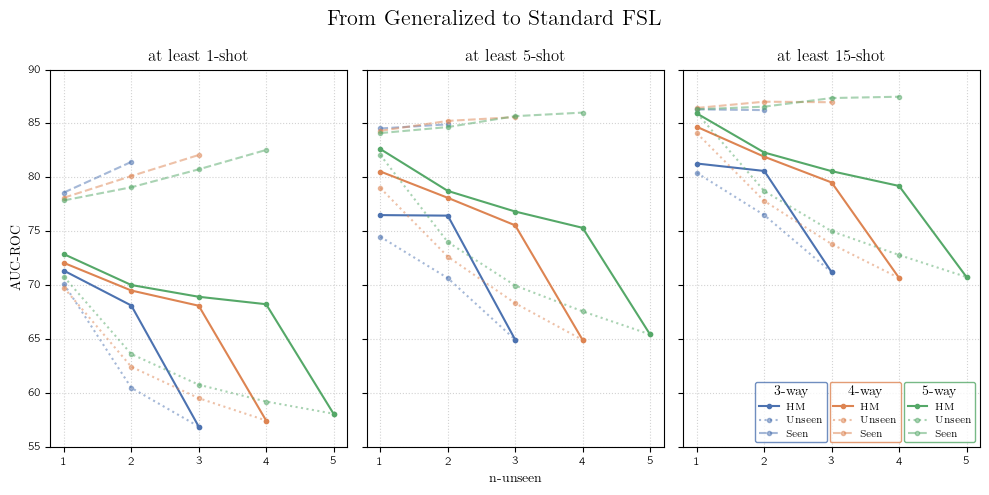

In [ ]:
def generate_gfsl_k_shot(df, k_shot, ax: Axes):

    n_ways = (3, 4, 5)
    num_n_ways = len(n_ways)
    colors = color_palette[:num_n_ways]

    for n_way, color in zip(n_ways, colors):
        subdf = df[df['n-way'] == n_way]

        subdf.plot(x='n-unseen', y='HM',
                   ax=ax,
                   marker='.', linestyle='solid',
                   color=color)
        subdf.plot(x='n-unseen', y='Unseen',
                   ax=ax,
                   marker='.', linestyle='dotted',
                   color=color, alpha=0.5)
        subdf.plot(x='n-unseen', y='Seen',
                   ax=ax,
                   marker='.', linestyle='dashed',
                   color=color, alpha=0.5)

        ax.get_legend().remove()


        if k_shot != 1:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('AUC-ROC')

        if k_shot != 5:
            ax.set_xlabel('')

        if k_shot == 15:
            leg = Legend(ax, ax.get_lines()[-3:],
                        ['HM', 'Unseen', 'Seen'],
                        title=f'{n_way}-way',
                        fontsize='x-small',
                        edgecolor=color,
                        loc='lower right')
            bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
            x_offset = (n_way - 5) * 0.25
            bb.x0 += x_offset
            bb.x1 += x_offset
            leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
            ax.add_artist(leg)

        ax.set_title(f'at least {k_shot}-shot')
        ax.tick_params(axis='both', which='major', labelsize='small')
        ax.tick_params(axis='both', which='minor', labelsize='small')
        ax.grid()
        ax.set_ylim(55, 90)


def generate_gfsl_group_by_k_shot(df):
    df = df.copy()

    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    for (k_shot, k_shot_df), ax in zip(df.groupby('k-shot'), axs):
        k_shot_df = k_shot_df.drop(columns=['k-shot'])
        with open(f'gfsl_{k_shot:02d}-shot.tex', 'w') as f:
            formatters = [format_pm] * k_shot_df.shape[1]
            f.write(k_shot_df.fillna(' '*12).to_latex(index=False, formatters=formatters))
        print(k_shot_df)

        k_shot_df['Unseen'] = k_shot_df['Unseen'].str[:5].astype(float)
        k_shot_df['Seen'] = k_shot_df['Seen'].str[:5].astype(float)
        k_shot_df['HM'] = k_shot_df['HM'].str[:5].astype(float)
        generate_gfsl_k_shot(k_shot_df, k_shot, ax)


    fig.suptitle('From Generalized to Standard FSL', fontsize=16)
    plt.tight_layout()
    plt.savefig(join(plots_dir, "gfsl_by_k-shot.pdf"))
    plt.show()

generate_gfsl_group_by_k_shot(gfsl_df)
